# 数据优化

In [1]:
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import os

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

## 数据批量读取

In [2]:
from_path = r"E:\Neteaseimport城市\4.处理数据\workingdata3"
to_path = r"E:\Netease\智慧城市\4.处理数据\workingdata4"

triptype_lst = ["越野跑","滑翔伞","crosscountry","观光旅行","其他","Gps作画","骑行","徒步","山地骑行","跑步","摩托车","寻宝","自驾车","滑雪","摄影","登山"]
d_dic = {"徒步":0.1,
        "越野跑":0.2,"跑步":0.2,
        "自驾车":1,
        "摩托车":1,
        "其他":1,
        "登山":0.1,
        "观光旅行":0.1,
        "骑行":0.2,"山地骑行":0.2}

## 数据批量优化

In [3]:
# 定义一个函数，用于删除线段中的误差点，并返回一个分割后的线段列表
def split_line(line, d):
    # 初始化一个空列表，用于存储分割后的线段
    segments = []
    # 初始化一个空列表，用于存储当前线段的节点
    current = []
    # 遍历线段中的所有节点
    for p in line.coords:
        # 如果当前线段为空，就将当前节点作为第一个节点
        if not current:
            current.append(p)
        # 否则，就计算当前节点与前一个节点的距离
        else:
            dist = shapely.geometry.Point(p).distance(shapely.geometry.Point(current[-1]))
            # 如果距离不超过阈值d，就将当前节点添加到当前线段中
            if dist <= d:
                current.append(p)
            # 否则，就将足够长的当前线段转换为LineString对象，并添加到分割后的线段列表中
            elif dist > d and len(current)>1:
                segments.append(shapely.geometry.LineString(current))
                # 然后清空当前线段，并将当前节点作为新线段的第一个节点
                current = [p]
            else: current = [p]
    # 如果当前线段足够长，就将其转换为LineString对象，并添加到分割后的线段列表中
    if len(current)>1:
        segments.append(shapely.geometry.LineString(current))
    # 返回分割后的线段列表
    return segments

# 定义一个函数，用于对GeoDataFrame对象中的所有线段进行切分，并返回一个新的GeoDataFrame对象
def split_lines(gdf, d):
    # 使用apply方法，对GeoDataFrame对象中的geometry列中的每个元素（即LineString对象）调用split_line函数，并得到一个新的列，其中每个元素是一个分割后的线段列表
    new_lines = gdf.geometry.apply(split_line, args=(d,))
    # 使用explode方法，将新列中的每个元素（即分割后的线段列表）展开为多行，并得到一个新的GeoSeries对象
    new_gseries = new_lines.explode()
    # 将新GeoSeries对象转换为GeoDataFrame对象，并设置crs属性为原GeoDataFrame对象的crs属性，并返回
    return gpd.GeoDataFrame(geometry=new_gseries, crs=gdf.crs)

In [4]:
for triptype, d in d_dic.items():
    gdf = gpd.read_file(from_path+r'\track_{}.shp'.format(triptype))
    new_gdf = split_lines(gdf, d)
    new_gdf.to_file(os.path.join(to_path,"track_{}_clean.shp".format(triptype)))
    print(triptype,len(gdf),len(new_gdf))

徒步 467093 467167
越野跑 4043 4043
跑步 31931 31935
自驾车 84154 84154
摩托车 3392 3392
其他 58597 58597
登山 862189 862288
观光旅行 2409452 2409881
骑行 127399 127399
山地骑行 19795 19795


## 优化前数据查看

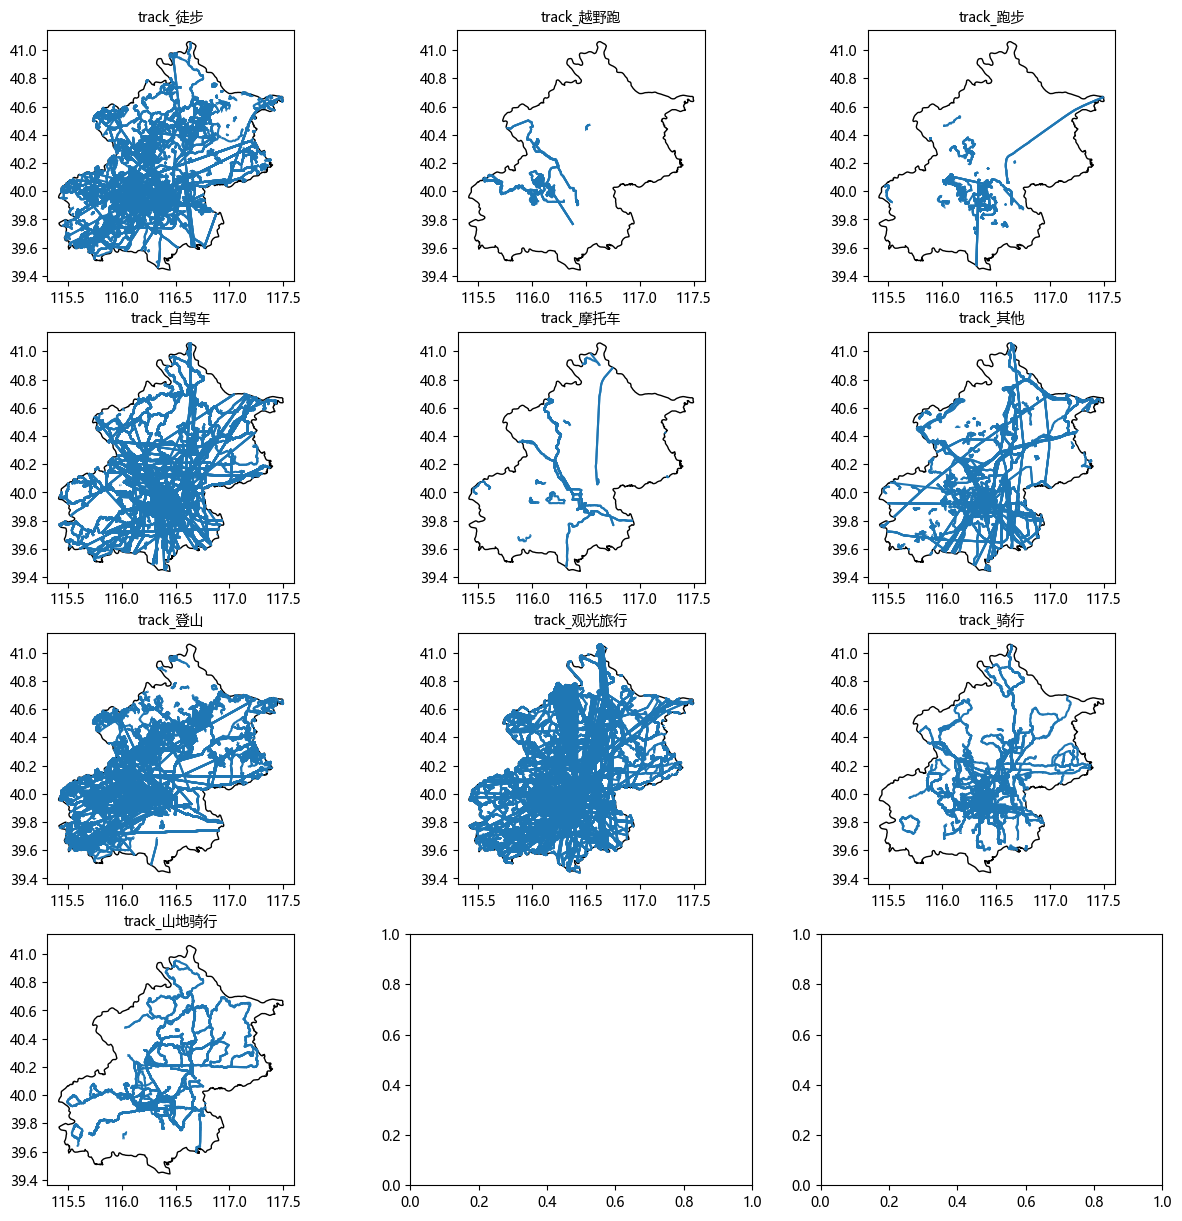

In [22]:
#### 合并数据查看
x_size,y_size = [4,3]
fig,axes = plt.subplots(x_size,y_size,figsize=(15,15))
df_bj = gpd.read_file(r"E:\Netease\智慧城市\4.处理数据\rawdata\北京市行政边界.shp")

for n,triptype in enumerate(d_dic.keys()):
    # 绘制北京市边界
    df_bj.plot(ax=axes[n//y_size,n%y_size],color="none",legend=False)

    # 增绘轨迹位置
    df_clean = gpd.read_file(os.path.join(from_path,"track_{}.shp".format(triptype)))
    df_clean.plot(ax=axes[n//y_size,n%y_size])

    # 设置标题
    axes[n//y_size,n%y_size].set_title("track_{}".format(triptype),fontsize=10)

plt.show()

## 优化后数据查看

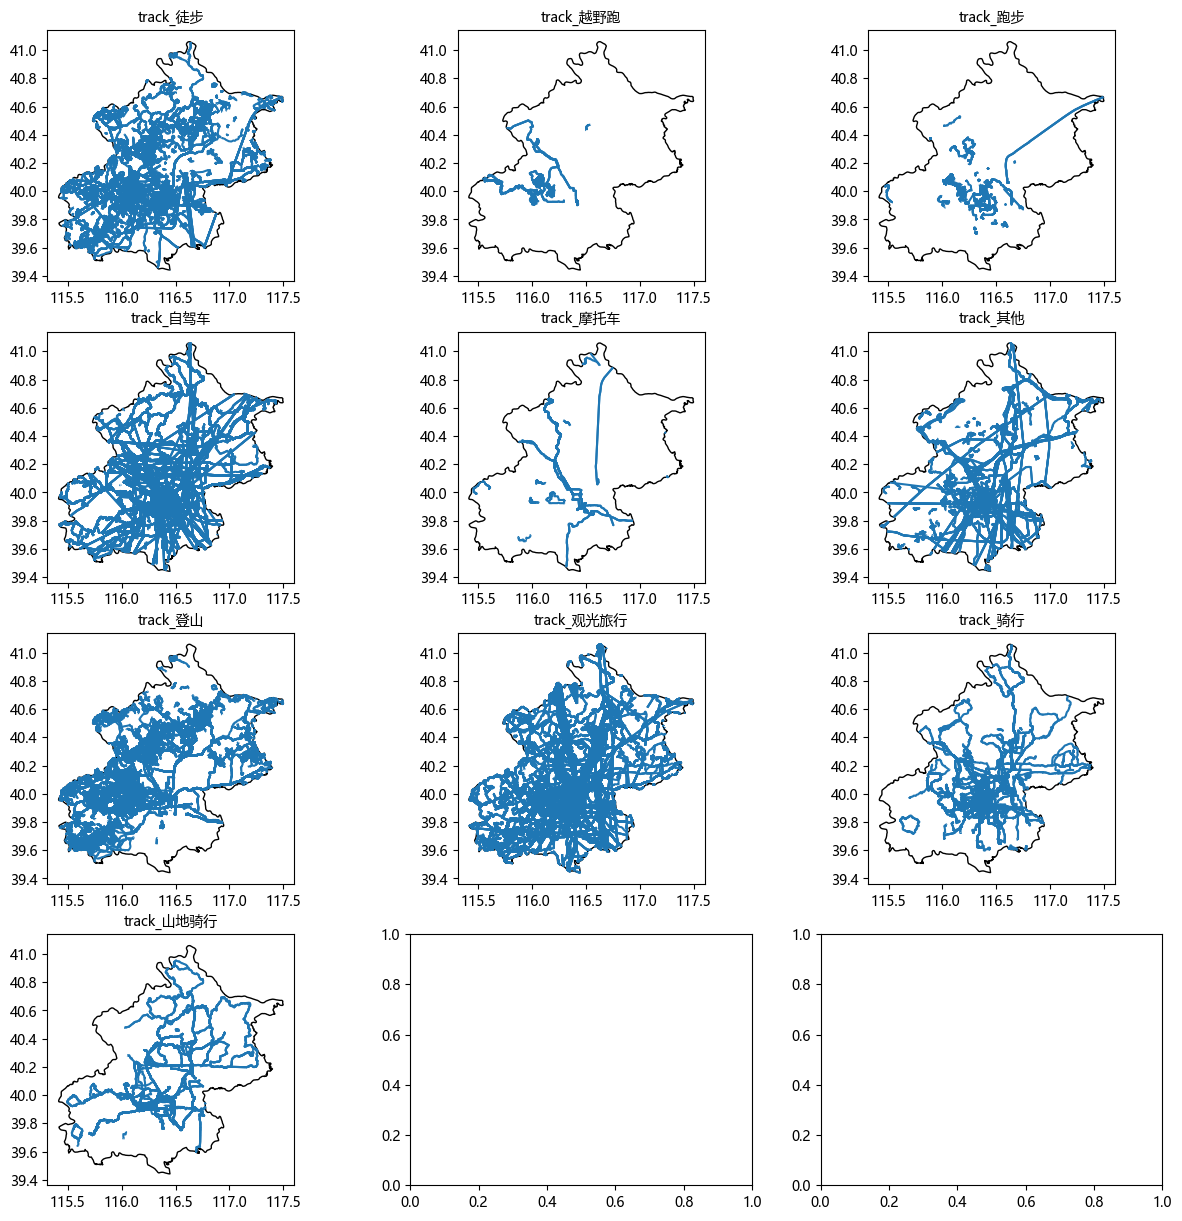

In [5]:
#### 合并数据查看
x_size,y_size = [4,3]
fig,axes = plt.subplots(x_size,y_size,figsize=(15,15))
df_bj = gpd.read_file(r"E:\Netease\智慧城市\4.处理数据\rawdata\北京市行政边界.shp")
df_bj = df_bj.to_crs(epsg = 4326)

for n,triptype in enumerate(d_dic.keys()):
    # 绘制北京市边界
    df_bj.plot(ax=axes[n//y_size,n%y_size],color="none",legend=False)

    # 增绘轨迹位置
    df_clean = gpd.read_file(os.path.join(to_path,"track_{}_clean.shp".format(triptype)))
    df_clean.plot(ax=axes[n//y_size,n%y_size])
    df_clean = df_clean.set_crs(epsg = 4326)

    # 设置标题
    axes[n//y_size,n%y_size].set_title("track_{}".format(triptype),fontsize=10)

plt.show()

In [6]:
plt.savefig("E:\\Netease\\智慧城市\\4.处理数据\\outputs\\分类清洗后图片2.png")

<Figure size 640x480 with 0 Axes>